In [4]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from plotnine import (element_blank, scale_color_manual, scale_x_continuous, ggplot, aes, geom_line ,geom_bar, geom_point, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [7]:
# defin path and load train and test data 
final_data_path = 'model/5.Stacking/stacking layer2 output/'
tr = pd.read_csv(final_data_path + 'train_layer2.csv')
te = pd.read_csv(final_data_path + 'test_layer2.csv')
tr.replace([np.nan], -9999, inplace=True)
te.replace([np.nan], -9999, inplace=True)
gc.collect()

21

In [6]:
from sklearn.preprocessing import StandardScaler

cols = tr.iloc[:, 20:].columns
cols = list(set(cols) - set(['Response']))

scaler = StandardScaler()
scaler.fit(tr[cols]) 

tr[cols] = scaler.transform(tr[cols])
te[cols] = scaler.transform(te[cols])

In [8]:
# train_x, train_y 
x = tr.drop(['index','Id', 'Response'], axis = 1)
y = tr['Response']
print(x.shape)
print(y.shape)

(1183747, 68)
(1183747,)


In [10]:
def best_thr_mcc(preds, va_y):
    thresholds = np.linspace(0.30, 0.50, 7)
    mcc = np.array([matthews_corrcoef(va_y, preds > thr)
                   for thr in thresholds])
    best_thr = thresholds[np.argmax(mcc)]
    best_score = mcc.max()
    return best_thr, best_score


def hp_train_model(x = x, y = y, params = None):
    
    mcc_scores = []

    tr_x, va_x, tr_y, va_y = train_test_split(x, y, test_size = 0.2, random_state = 70, shuffle = True)

    clf = RandomForestClassifier(n_estimators = params['n_estimators'], 
                                 max_depth = params['max_depth'],
                                 min_samples_leaf = params['min_samples_leaf'],
                                 min_samples_split = params['min_samples_split'],
                                 n_jobs = 7, random_state = 123)
    clf.fit(tr_x, tr_y)
    va_pred = clf.predict_proba(va_x)[:, 1]
        
    _, mcc_value= best_thr_mcc(va_pred, va_y)
    mcc_scores.append(mcc_value)

    history.append((params, mcc_value))

    print('curent hyperparameters: ', params)
    print('mcc value: {}'.format(round(mcc_value, 3)))
    print('='*20)
    gc.collect()

    return np.mean(mcc_scores)

def hp_rf_model(params):
    
    rf_params = {'n_estimators': int(params['n_estimators']), 
                 'max_depth': int(params['max_depth']),
                 'min_samples_leaf': int(params['min_samples_leaf']),
                 'min_samples_split': int(params['min_samples_split'])
                  }
                        
    score = hp_train_model(params = rf_params)
    return {'loss':-score, 'status': STATUS_OK}


In [ ]:
space = {
         'n_estimators'    : hp.quniform('n_estimators', 600, 670, 25),
         'max_depth'       : hp.quniform('max_depth', 25, 35, 2),
         'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 4, 1),
         'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1)
        }

history = []
trials = Trials()
best = fmin(fn = hp_rf_model, space = space, algo = tpe.suggest, max_evals = 10, trials = trials)
print('='*40)
print(best)

In [223]:
sorted(history, key = lambda x:x[1])[-1]

({'n_estimators': 650,
  'max_depth': 30,
  'min_samples_leaf': 2,
  'min_samples_split': 4},
 0.45001197896795164)

In [12]:
best = {'n_estimators': 650,
  'max_depth': 30,
  'min_samples_leaf': 2,
  'min_samples_split': 4}

In [14]:
def train_model(x = x, y = y, params = None, te = te, n_fold = 5):
    
    kf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 123)

    scores = {'fold':[], 'mcc':[], 'g_means':[], 'auc_scores':[], 'f1_scores':[], 'threshold':[]}

    predictions = np.zeros(len(te))
    feature_importances = 0

    for fold_i, (tr_idx, va_idx) in enumerate(kf.split(x, y)):
    

        tr_x, va_x = x.iloc[tr_idx], x.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]


        clf = RandomForestClassifier(n_estimators = params['n_estimators'], 
                                     max_depth = params['max_depth'],
                                     min_samples_leaf = params['min_samples_leaf'],
                                     min_samples_split = params['min_samples_split'],
                                     n_jobs = 7, random_state = 122)

        clf.fit(tr_x, tr_y)
        va_pred = clf.predict_proba(va_x)[:, 1]
        
        prediction = clf.predict_proba(te.drop(['Id'], axis = 1))[:, 1]
        predictions += prediction

        feature_importances_ = clf.feature_importances_
        feature_importances += feature_importances_
        
        if (fold_i + 1) == n_fold:
            predictions /= (fold_i + 1)
            feature_importances /= (fold_i + 1)

        best_thresh, mcc_value= best_thr_mcc(va_pred, va_y)
        y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

        tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
        spec = tn / (tn + fp)
        sens = tp / (tp + fn)
        g_means = np.sqrt(spec * sens)
        fmeasure = f1_score(va_y, y_pred)
        auc_score = roc_auc_score(va_y, y_pred)

        print('fold {}'.format(fold_i + 1))
        print('mcc value: {}'.format(round(mcc_value, 3)))
        print('g_means value: {}'.format(round(g_means, 3)))
        print('auc value: {}'.format(round(auc_score, 3)))
        print('f1_score value: {}'.format(round(fmeasure, 3)))
        print('threshold: {}'.format(round(best_thresh, 3)))
        print('='*20)
        
        scores['fold'].append(fold_i + 1)
        scores['mcc'].append(mcc_value)
        scores['g_means'].append(g_means)
        scores['f1_scores'].append(fmeasure)
        scores['auc_scores'].append(auc_score)
        scores['threshold'].append(best_thresh)
        
        gc.collect()
    
    return clf, scores, predictions, feature_importances

def rf_model(params):
    
    rf_params = {'n_estimators': int(params['n_estimators']), 
                 'max_depth': int(params['max_depth']),
                 'min_samples_leaf': int(params['min_samples_leaf']),
                 'min_samples_split': int(params['min_samples_split'])
                  }
                        
    clf, scores, predictions, feature_importances = train_model(params = rf_params)
    return clf, scores, predictions, feature_importances

In [15]:
clf, scores, predictions, feature_importances = rf_model(best)

fold 1
mcc value: 0.445
g_means value: 0.528
auc value: 0.639
f1_score value: 0.402
threshold: 0.333
fold 2
mcc value: 0.459
g_means value: 0.509
auc value: 0.629
f1_score value: 0.393
threshold: 0.458
fold 3
mcc value: 0.442
g_means value: 0.487
auc value: 0.618
f1_score value: 0.369
threshold: 0.5
fold 4
mcc value: 0.477
g_means value: 0.536
auc value: 0.644
f1_score value: 0.423
threshold: 0.375
fold 5
mcc value: 0.437
g_means value: 0.478
auc value: 0.614
f1_score value: 0.36
threshold: 0.458


In [272]:
pd.DataFrame(scores)

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.446464,0.504960,0.627342,0.385291,0.366667
1,2,0.446207,0.514203,0.632021,0.392241,0.366667
2,3,0.444525,0.491306,0.620576,0.373453,0.411111
3,4,0.472389,0.529536,0.640058,0.415501,0.366667
4,5,0.433579,0.485166,0.617565,0.364250,0.411111


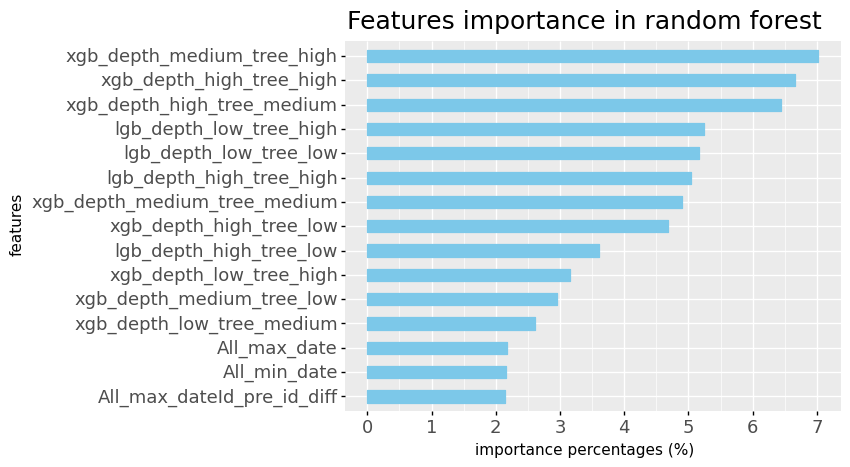

<ggplot: (-9223371911774046364)>

In [17]:
keys = list(x.columns)
values = list(feature_importances)
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))

g = (
    ggplot(feat_imp.iloc[-15:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = np.arange(0, 20, 1))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance in random forest')
)
# ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [18]:
path = 'model/5.Stacking/stacking output/'
pd.DataFrame({'parameters': best}).to_csv(path + 'best_parameters.csv', index = True)
# best = pd.read_csv(path + 'best_parameters.csv', index_col = 0).to_dict

pd.DataFrame(scores).to_csv(path + 'randomforest_scores.csv', index = False)
# loss_data.to_csv(path + 'randomforest_loss_data.csv', index = False)
# clf.save_model(path + "randomforest_model.json")

# private: 0.46694
submission = pd.DataFrame({'Id': te['Id'], 'Response': predictions > np.mean(scores['threshold'])})
submission['Response'] = submission['Response'].astype('int')
submission.to_csv(path + 'submission_stacking output ver4 randomforest.csv', index = 0)

In [21]:

joblib.dump(clf, path + "random_forest.joblib")
loaded_rf = joblib.load(path + "random_forest.joblib")